In [1]:
import torch
from torch import nn
from torch import optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Testdaten laden und vorbereiten

In [2]:
data_dir = 'data/flowers'

# Define transforms for the testing data
test_transforms = transforms.Compose([
                                    transforms.Resize(225),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor()
                                   ])
# Pass transform and get augmanted data here
test_data = datasets.ImageFolder(data_dir+'/test', transform=test_transforms)
# prepare data loaders (combine dataset and sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))

In [3]:
print("Number of test data     :", len(test_data))

Number of test data     : 66


### Zeigt einige Beispielbilder aus vorbereiteten Testdaten

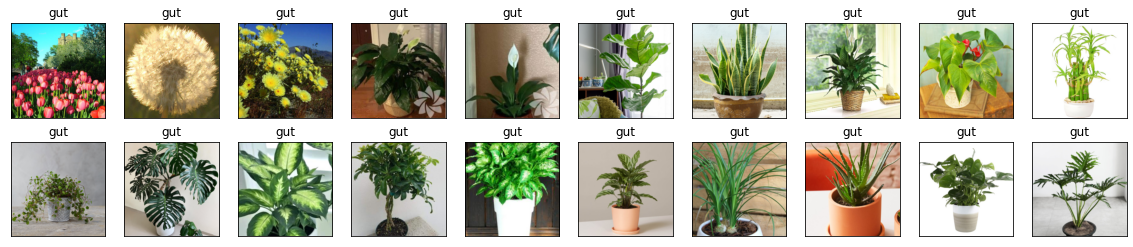

In [4]:
# specify the image classes
classes = ['gut', 'durstig']

# get one batch of training images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot some images with corresponding labels
fig = plt.figure(figsize=(20, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
#     plt.imshow(images[idx])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

### Model definieren und seine Parametern einfrieren

In [5]:
model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

### Gerät definieren

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Model will work on {device.type}.")

Model will work on cpu.


In [7]:
model.classifier = nn.Sequential(
                                 nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1)
                                )
# NLLLoss: The negative log likelihood loss.
criterion = nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

### Trainertes Model Laden

In [8]:
model.load_state_dict(torch.load('model_290522_2114.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

### Prüfe Das Model

In [9]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
# Accumulate mispredicted pictures
mispred_pictures = list()
# Accumulate mispredicted picture infos
info_mispreds = list()

model.eval()
# iterate over test data
for inputs, labels in test_loader:
    # move tensors to GPU if CUDA is available
    inputs, labels = inputs.to(device), labels.to(device)
    # forward pass
    logprobs = model.forward(inputs)    
    # calculate the batch loss
    batch_loss = criterion(logprobs, labels)
    # update test loss
    test_loss += batch_loss.item()*inputs.size(0)
    # change negative probabilities to positive numbers
    probs = torch.exp(logprobs)
    # get top probabilities and their indexes
    top_scrs, top_idxes = probs.topk(1, dim=1)
    # create boolean mask for idxes as True, False format
    equals = (top_idxes == labels.view(*top_idxes.shape)).squeeze()    
    # fill class_correct and class_total lists
    for i in range(inputs.size(0)):
        label = labels.data[i]
        class_correct[label] += equals[i].item()
        class_total[label] += 1
    # get misspredicted pictur indexes    
    misspred = (equals == 0).nonzero()
    # save that pictures and their predictions
    for idx in misspred:
        mispred_picture = inputs[idx]#.numpy().squeeze()        
        prediction = top_idxes[idx].item()
        real = labels[idx].item()
        mispred_pictures.append(mispred_picture)
        info_mispreds.append([prediction, real, top_scrs[idx].item(), idx])        
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
# print accuracy of each type of inputs
for i in range(2):
    if class_total[i] > 0:
        print(
              f'Test Accuracy of {classes[i]:s}: '
              f'{100 * class_correct[i] / class_total[i]:.2f} '
              f'({np.sum(class_correct[i]):.0f}/{np.sum(class_total[i]):.0f})'
             ) 
    else:
        print(f'Test Accuracy of {classes[i]:s}: N/A (no training examples)')

print(
      f'\nTest Accuracy (Overall): '
      f'{100. * np.sum(class_correct) / np.sum(class_total):.2f}' 
      f'({np.sum(class_correct):.0f}/{np.sum(class_total):.0f})'
     )

Test Loss: 0.249277

Test Accuracy of gut: 96.97 (32/33)
Test Accuracy of durstig: 93.94 (31/33)

Test Accuracy (Overall): 95.45(63/66)


In [10]:
info_mispreds

[[1, 0, 0.8799819350242615, tensor([3])],
 [0, 1, 0.5846832990646362, tensor([37])],
 [0, 1, 0.9904848337173462, tensor([38])]]

### Zeige falsch klassifizierte Bilder an

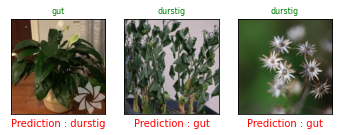

In [11]:
# plot some images with corresponding labels
fig = plt.figure(figsize=(20, 4))
# display 20 images
for i in range(len(mispred_pictures)):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(mispred_pictures[i].numpy().squeeze(), (1, 2, 0)))
    ax.set_title(classes[info_mispreds[i][1]], color='g', fontsize=8)
    plt.xlabel(f"Prediction : {classes[info_mispreds[i][0]]:^s}", color='r')    

## Interpretation

In [12]:
from PIL import Image

from matplotlib.colors import LinearSegmentedColormap

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

Auf welches Bild möchten Sie sich konzentrieren?

In [13]:
img_idx = 2
pred_label_idx = info_mispreds[img_idx][3]
transformed_img = mispred_pictures[img_idx]

In [14]:
input = transformed_img
input.requires_grad = True

In [15]:
output = model(input)
output

tensor([[-0.0096, -4.6549]], grad_fn=<LogSoftmaxBackward0>)

### Gradient-based attribution

Let's compute attributions using Integrated Gradients and visualize them on the image. Integrated gradients computes the integral of the gradients of the output of the model for the predicted class `pred_label_idx` with respect to the input image pixels along the path from the black image to our input image.

In [ ]:
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=info_mispreds[img_idx][1], n_steps=200)


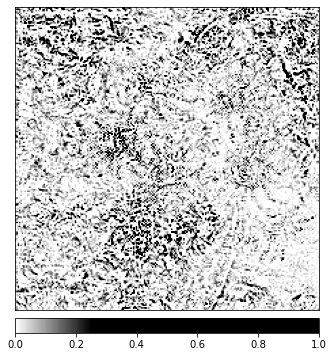

In [20]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
# visualize the image and corresponding attributions by overlaying the latter on the image.
_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(mispred_pictures[img_idx].squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

Let us compute attributions using Integrated Gradients and smoothens them across multiple images generated by a noise tunnel. The latter adds gaussian noise with a std equals to one, 10 times (nt_samples=10) to the input. Ultimately, noise tunnel smoothens the attributions across nt_samples noisy samples using smoothgrad_sq technique. smoothgrad_sq represents the mean of the squared attributions across nt_samples samples.

In [16]:
integrated_gradients = IntegratedGradients(model)
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(mispred_pictures[img_idx].cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 652288000 bytes.

Finally, let us use GradientShap, a linear explanation model which uses a distribution of reference samples (in this case two images) to explain predictions of the model. It computes the expectation of gradients for an input which was chosen randomly between the input and a baseline. The baseline is also chosen randomly from given baseline distribution.

In [24]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 40140800 bytes.